# Neu 501a
## Topic: Population Coding

### Problem 1a
Simulate a population of 21 independent Poisson neurons with Gaussian-shaped tuning curves $f_i(x)$ that have an amplitude of 15 and a standard deviation $\sigma_i$ = 1, with centers $\mu_i$ evenly spaced between -10 and +10 on the x axis. That is, let tuning curve of the $i$th neuron be: 

> $f_i(x) = 15 \cdot exp(-\frac{(x-\mu_i)^2}{2\sigma^2_i})$

Plot all the tuning curves on one axis. 

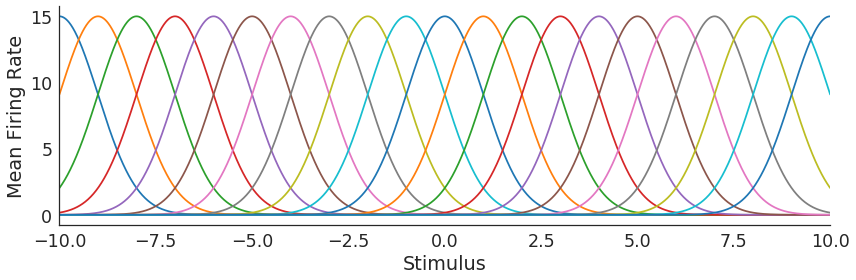

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define paramters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Tuning curve parameters.
S = np.linspace(-10,10,21) # Stimulus preferences.
sd = 1                     # Width
A = 15                     # Amplitude

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate tuning curves.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def gaussian_curve(x, mu=0, sd=1, A=1):
    '''Generates Gaussian curve of specified parameters across array
    
    INPUTS
    --  x: array of points
    -- mu: center of Gaussian curve
    -- sd: standard deviation of Gaussian curve
    --  A: amplitude of Gaussian curve'''
    return A * np.exp(-np.power(x-mu,2)/(2*sd**2) )

## Define stimulus axis. 
x = np.arange(S.min(), S.max() + 1e-6, 1e-2).round(2)

## Simulate tuning curves.
tuning_curves = np.array([gaussian_curve(x, s, sd=sd, A=A) for s in S])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot tuning curves.
ax.plot(x, tuning_curves.T)
ax.set(xlim=(x.min(), x.max()), xlabel='Stimulus', ylabel='Mean Firing Rate')

sns.despine()
plt.tight_layout()

### Problem 1b
Simulate the population response to the stimulus x = −1 and plot the population response as a function of each neuron’s preferred orientation.

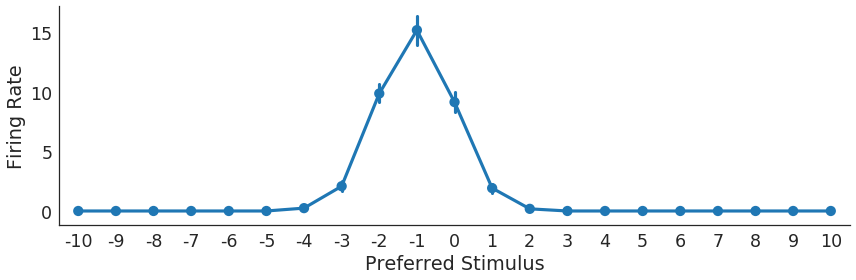

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate population response.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define number of simulations.
n_sim = 50

## Simulate spikes: randomly sample from a Poisson distribution 
## with lambda equal to the corresponding amplitude of each tuning
## curve at stimulus (x) = -1. 
spikes = np.array([np.random.poisson(gaussian_curve(-1, s, sd=sd, A=A), n_sim) for s in S])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
sns.pointplot(data=spikes.T, ci=95, ax=ax)
ax.set(xticklabels=S.astype(int), xlabel='Preferred Stimulus', ylabel='Firing Rate')

sns.despine()
plt.tight_layout()

### Problem 2
Write functions to perform winner-take-all decoding, center-of-mass decoding, template-matching decoding, maximum-likelihood, and maximum *a posteriori* (MAP) decoding given a vector of neural responses, $r$.

#### Winner-Take-All

In [3]:
def winner_take_all(S, R):
    '''For an array of stimulus preferences (S) and a vector
    of neural responses (R), return that stimulus corresponding
    to the highest firing rate (R_max)'''
    return S[np.argmax(R)]

#### Center-of-Mass

In [4]:
def center_of_mass(S, R):
    '''For an array of stimulus preferences (S) and a vector
    of neural responses (R), return the average stimulus
    weighted by the firing rate'''
    return np.inner(S,R) / np.sum(R)

#### Template-Matching

In [5]:
def gaussian_curve_fixed(x, mu):
    '''Convenience function: Gaussian curve fixed at A=15, sd=1'''
    return 15 * np.exp(-np.power(x-mu,2)/(2*1**2) )

def template_matching(S, R, grid):
    '''For an array of stimulus preferences (S) and a vector
    of neural responses (R), return the stimulus at which
    a fixed Gaussian curve (sd=1, A=15) best fits the observed 
    firing rates
    
    INPUTS
    -- S: array of stimulus preferences
    -- R: array of neural responses
    -- grid: candidate values of S_hat to perform grid search over.'''
    
    ## Define error function.
    f = lambda S, R, g: np.power( gaussian_curve_fixed(S, g) - R, 2 ).sum()
    
    ## Perform grid search. Return stimulus that minimizes error.
    errors = [f(S, R, g) for g in grid]
    return grid[np.argmin(errors)]

#### Maximum Likelihood

In [6]:
from scipy.optimize import minimize
from scipy.special import gammaln

def poisson_log_pdf(k, l):
    '''kappa (k): observed number of events
       lambda (l): expected number of events'''
    return -l + k*np.log(l) - gammaln(k+1)

def poisson_loglik(x, S, R):
    '''For an array of stimulus preferences (S) and a vector of 
    neural responses (R), compute the log-likelihood of a
    stimulus preference, x, assuming Poisson-distributed neurons'''
    tuning_curve = gaussian_curve_fixed(S, x)
    return -np.sum([poisson_log_pdf(k, l) for k, l in zip(R, tuning_curve)])

def maximum_likelihood(S, R, grid=False, optimize=False):
    '''For an array of stimulus preferences (S) and a vector
    of neural responses (R), return the stimulus that maximizes
    the likelihood of the observed firing rate assuming Poisson-
    distributed neurons.
    
    INPUTS
    -- S: array of stimulus preferences
    -- R: array of neural responses
    -- grid: candidate values of S_hat to perform grid search over
    -- optimize: if set to True, use gradient descent to maximize likelihood'''
    
    ## SciPy minimize.
    if np.any(optimize):
        result = minimize(poisson_loglik, x0=0, args=(S, R))
        x = result.x[0]
        
    ## Grid search.
    elif np.any(grid):
        loglik = [poisson_loglik(g, S, R) for g in grid]
        x = grid[np.argmin(loglik)]
    
    ## Error catching.
    else:
        raise ValueError('Must use either grid search or gradient descent.')
    
    return x

#### Maximum A Posteriori 

In [7]:
def uniform_log_pdf(x, a, b):
    '''x: observed value
       a: lower limit
       b: upper limit'''
    if np.logical_and(x >= a, x <= b): 
        return np.log( 1. / (b-a) )
    else:
        return -np.inf
    
def normal_log_pdf(x, mu, sd):
    '''x: observed value
       mu: center
       sd: standard deviation'''
    return -0.5 * np.log(2*np.pi) - 0.5 * np.log(sd**2) - 0.5 * (sd**-2) * (x - mu)**2

def maximum_a_posteriori(S, R, prior, prior_args, grid=False, optimize=False):
    '''For an array of stimulus preferences (S) and a vector
    of neural responses (R), return the stimulus that maximizes
    the likelihood of the observed firing rate, assuming Poisson-
    distributed neurons, conditioned on a specified prior.
    
    INPUTS
    -- S: array of stimulus preferences
    -- R: array of neural responses
    -- prior: a specified prior function, the log PDF of a distribution
    -- prior_args: parameters for the prior
    -- grid: candidate values of S_hat to perform grid search over
    -- optimize: if set to True, use gradient descent to maximize likelihood'''
        
    ## Define error function.
    f = lambda x, S, R: -prior(x, *prior_args) + poisson_loglik(x, S, R)
    
   ## SciPy minimize.
    if np.any(optimize):
        result = minimize(f, x0=0, args=(S, R))
        x = result.x[0]
        
    ## Grid search.
    elif np.any(grid):
        loglik = [f(g, S, R) for g in grid]
        x = grid[np.argmin(loglik)]
    
    ## Error catching.
    else:
        raise ValueError('Must use either grid search or gradient descent.')
        
    return x

### Problem 3a
Perform a simulated experiment consisting of 100 repetitions of the following: draw x from a Gaussian with mean 0 and standard deviation 3. Simulate the population response, $r$, and compute the stimulus estimate using each of the decoders listed above. 

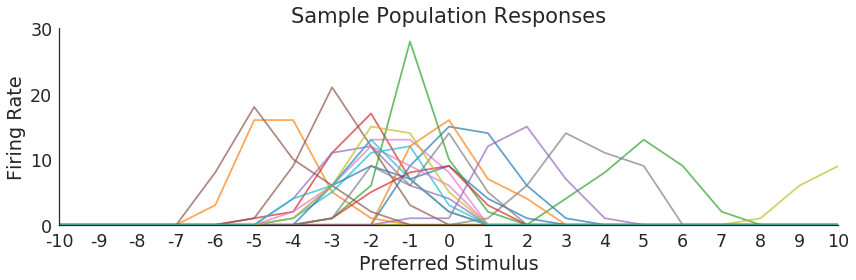

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate population responses.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define paramters.
n_sim = 100

## Draw X randomly.
X = np.random.normal(0, 3, n_sim)

## Prealloate space.
R = np.zeros((X.size, S.size))

## Simulate population response. Randomly sample from a 
## Poisson distribution with lambda equal to the corresponding 
## amplitude, X, generated above.
for n, x in enumerate(X):
    R[n] = [np.random.poisson(gaussian_curve(x, s, sd=sd, A=A), 1) for s in S]
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
ax.plot(S, R[::5].T, alpha=0.7)
ax.set(xlim=(S.min(), S.max()), xticks=S, xticklabels=S.astype(int), ylim=(0,30),
       xlabel='Preferred Stimulus', ylabel='Firing Rate', title='Sample Population Responses')

sns.despine()
plt.tight_layout()

### Problem 3b
Make a bar graph showing the average error for each of the decoders.

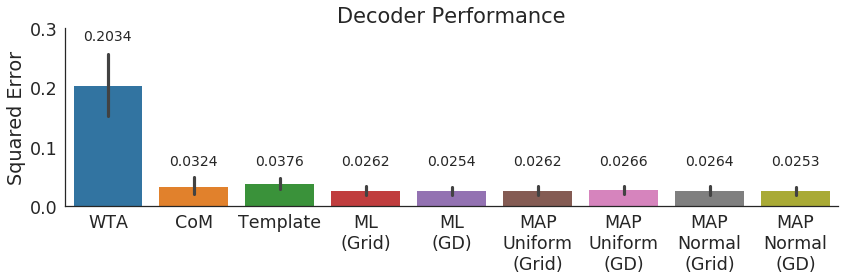

In [9]:
import warnings
warnings.filterwarnings("ignore")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Evaluate performance of decoders.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define grid for grid search.
grid = np.linspace(-10,10,1001)

## Preallocate space.
error = np.zeros((n_sim, 9))

## Compute errors.
for n, r in enumerate(R):
    
    ## Preallocate space.
    S_hat = np.zeros(9)
    
    ## Winner-take-all.
    S_hat[0] = winner_take_all(S, r)
    
    ## Center-of-mass.
    S_hat[1] = center_of_mass(S, r)
    
    ## Template-matching.
    S_hat[2] = template_matching(S, r, grid)
        
    ## Maximum likelihood (grid search).
    S_hat[3] = maximum_likelihood(S, r, grid=grid)
    
    ## Maximum likelihood (gradient descent).
    S_hat[4] = maximum_likelihood(S, r, optimize=True)
    
    ## Maximum a posteriori (uniform prior, grid search).
    S_hat[5] = maximum_a_posteriori(S, r, uniform_log_pdf, [-10,10], grid=grid)
    
    ## Maximum a posteriori (uniform prior, gradient descent).
    S_hat[6] = maximum_a_posteriori(S, r, uniform_log_pdf, [-10,10], optimize=True)
    
    ## Maximum a posteriori (normal prior, grid search).
    S_hat[7] = maximum_a_posteriori(S, r, normal_log_pdf, [0, 3], grid=grid)
    
    ## Maximum a posteriori (normal prior, gradient descent).
    S_hat[8] = maximum_a_posteriori(S, r, normal_log_pdf, [0, 3], optimize=True)
    
    ## Compute and store squared error.
    error[n] = np.power(S_hat - X[n], 2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, ax = plt.subplots(1,1,figsize=(12,4))

sns.barplot(data=error, ci=95, ax=ax)
ax.set(xticklabels=('WTA', 'CoM', 'Template', 'ML\n(Grid)', 'ML\n(GD)', 'MAP\nUniform\n(Grid)', 
                    'MAP\nUniform\n(GD)', 'MAP\nNormal\n(Grid)', 'MAP\nNormal\n(GD)'),
      ylim=(0, 0.3), ylabel='Squared Error', title='Decoder Performance')

for x, s in zip(ax.get_xticks(), error.mean(axis=0)):
    ax.text(x, 0.28 if not x else 0.07, '%0.4f' %s, ha='center', fontsize=14)

sns.despine()
plt.tight_layout()